# Define geospatial tasks for KGs

In [2]:
from functions.sparql_requests import sparql_select, replace_directions_python

In [3]:
import folium
import requests
import geopandas as gpd
from shapely import wkt
import contextily as ctx
import matplotlib.pyplot as plt
from shapely.geometry import shape
from matplotlib.patches import Patch

In [4]:
graphdb_server_url = 'http://localhost:7200'
repository_id = 'geonuts'
select_endpoint_url = f"http://localhost:7200/repositories/{repository_id}"
update_endpoint_url = f"http://localhost:7200/repositories/{repository_id}/statements"

## .1 Neighbors
Aggregating statistics with neighboring NUTS-regions:\
NUTS-areas are hierarchically organised. This means that aggregations of regions are predefined. For example the NUTS-region level 1 `AT1` encompasses the level 2 regions `AT11`, `AT12` and `AT13`. Statistics are collected on these regions. 

However, in some cases it could be interesting to analyse all bordering regions of a regions. For example the code `AT130`, level 3, (Vienna) neighbors `AT127`and `AT126` on the same level. These roughly encompass the Viennese metropolitain region, aggregating statistics for this case could be interesting, but would only be achievably with LLMs, if they clearly understand neighborhood relations.

Another potential use-case would be to look at each NUTS-region and calculate if it is richer or poorer than its neighbors.

It could also assist with calculation Moran's I for spatial autocorrelation.

In [6]:
with open("sparql/get_at22_neighbors.sparql", "r") as f:
    query_at22Neighbors = f.read()

at22_query = '''
PREFIX geo: <http://www.opengis.net/ont/geosparql#>

SELECT ?steiermark ?steiermark_geoWKT
WHERE {
  	?steiermark <http://purl.org/dc/elements/1.1/identifier> "AT22" .
    ?steiermark geo:hasGeometry ?steiermark_geo .
    ?steiermark_geo geo:asWKT ?steiermark_geoWKT .
}
'''

In [7]:
df = sparql_select(query_at22Neighbors, select_endpoint_url)
df['all_WKT'] = df['all_WKT'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df, geometry='all_WKT')

centroid = gdf.dissolve().geometry.centroid[0]
m = folium.Map(location=[centroid.y, centroid.x], zoom_start=8)

df_steiermark = sparql_select(at22_query, select_endpoint_url)
df_steiermark['steiermark_geoWKT'] = df_steiermark['steiermark_geoWKT'].apply(wkt.loads)
gdf_steiermark = gpd.GeoDataFrame(df_steiermark, geometry='steiermark_geoWKT')

<Axes: >

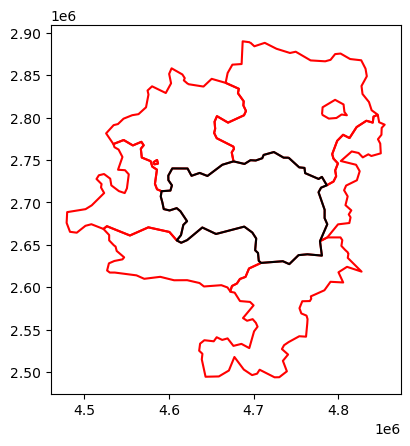

In [8]:
fig, ax = plt.subplots(1)
gdf.boundary.plot(ax=ax, markersize=4, color="red")
gdf_steiermark.boundary.plot(ax=ax, color='black')

## .2 Directions
What is east, west, north and south. Which NUTS-regions are west of region X? Which geographical features are north of region Y? Is my autocorellation anisotropic? Directions have to be clearly understood by the LLM in order to answer these questions.
Since directions are vague, assumptions and simplyfications will have to be made.

A formal definition of directions is given by Goyal & Egenhofer. It uses the bounding box of a polygon to seperate space into eight areas and the bounding box itself. The eight areas correspond to North, Northeast, East, Southeast, South, Southwest, West and Northwest.

However this has a few drawbacks. The areas are not equally big and it and seen from very small polygons or point data, the more known directions (North, West, East, South) are smaller. After some experimenting, I decided to switch to only using the 4 main directions for this study. These can then also modelled as boolean functions which is easier to understand and implement into SPARQL syntax. The intercardinal directions can be asked using a combination of the cardinal directions.

These directions do overlap in significant parts. Everything within the rectangle that encompasses everything with smaller X coordinates as the minx of the polygon in question will be considered west for example. This is designed so that functions that ask for directionality will return True or False, where multiple can be True. The LLM will (hopefully) be able to interpret this correctly.

One major this to consider is the projection EPSG:3035: here larger Y values do not nececarily mean further north. Therefore I designed a helper function that creates the four polygons in python in EPSG:4326 and then reprojects it to EPSG:3035. Since geosparql does not support reprojection this had to be done in python.

In [10]:
df = sparql_select(at22_query.replace("AT22", "DE11"), select_endpoint_url)
df['steiermark_geoWKT'] = df['steiermark_geoWKT'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df, geometry='steiermark_geoWKT', crs=3035)

df = sparql_select(at22_query.replace("AT22", "HR03"), select_endpoint_url)
df['steiermark_geoWKT'] = df['steiermark_geoWKT'].apply(wkt.loads)
gdf2 = gpd.GeoDataFrame(df, geometry='steiermark_geoWKT', crs=3035)

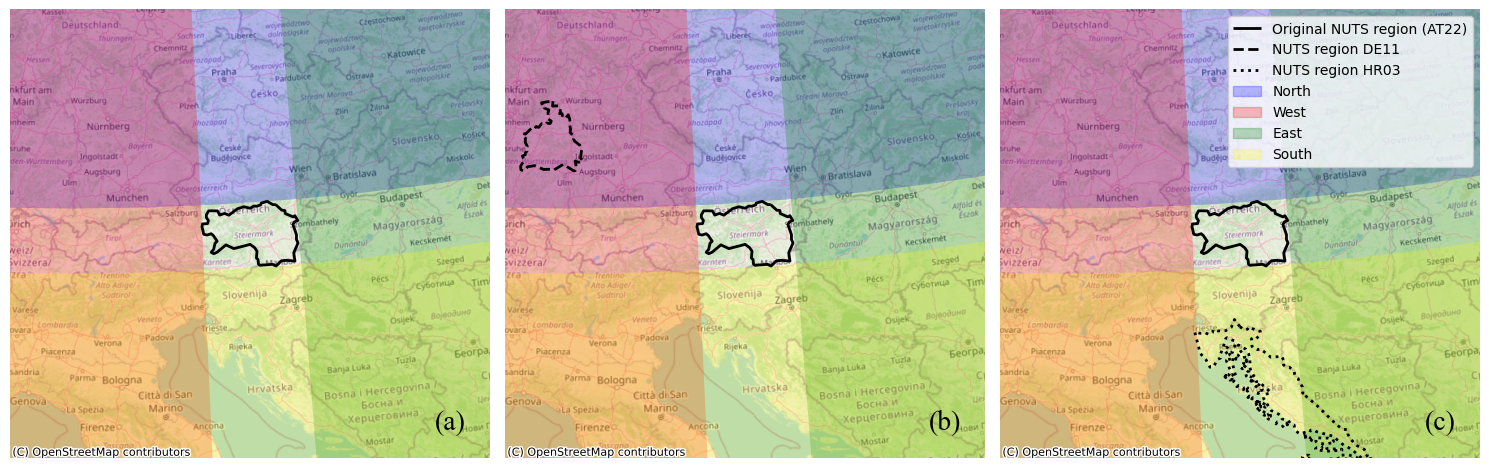

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

bounds = gdf_steiermark.bounds
minx, miny, maxx, maxy = bounds.iloc[0]

centroidx = (minx + maxx) / 2
centroidy = (miny + maxy) / 2

at22_query_temp = '''
PREFIX geo: <http://www.opengis.net/ont/geosparql#>

SELECT ?steiermark ?steiermark_geoWKT
WHERE {
  	?steiermark <http://purl.org/dc/elements/1.1/identifier> "AT22" .
    ?steiermark geo:hasGeometry ?steiermark_geo .
    ?steiermark_geo geo:asWKT ?steiermark_geoWKT .
    geof:isWestOf(?temp, ?steiermark_geoWKT)
}
'''

polys = replace_directions_python(at22_query_temp, return_polys=True)

colors = ["blue", "red", "green", "yellow"]
for i in range(3):
    gdf_steiermark.boundary.plot(ax=axs[i], color='black', label="Original NUTS region (AT22)", linewidth=2)

    for j, direction in enumerate(polys):
        p = gpd.GeoSeries(direction)
        p.plot(ax=axs[i], color=colors[j], alpha=0.25)

    axs[i].axis("off")

    padding = 2 * max(maxx - minx, maxy - miny)
    axs[i].set_xlim(minx - padding, maxx + padding)
    axs[i].set_ylim(miny - padding, maxy + padding)
    ctx.add_basemap(axs[i], crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

gdf.boundary.plot(ax=axs[1], color="black", linestyle="dashed", label="NUTS region DE11", zorder=100, linewidth=2)
gdf2.boundary.plot(ax=axs[2], color="black", linestyle="dotted", label="NUTS region HR03", zorder=100, linewidth=2)

handles, labels = axs[1].get_legend_handles_labels()
handles2, labels2 = axs[2].get_legend_handles_labels()
handles += [handles2[1]]
labels += [labels2[1]]
legend_patches = [
    Patch(color=colors[j], alpha=0.25, label=f'Polygon {j + 1}') for j in range(len(polys))
]
poly_labels = ["North", "West", "East", "South"]
handles += legend_patches
labels += poly_labels
axs[2].legend(handles=handles, labels=labels)
letters = ['a', 'b', 'c'] 

for i, ax in enumerate(axs):
    ax.text(0.95, 0.05, f"({letters[i]})", 
            transform=ax.transAxes,
            fontsize=20,
            fontdict={'family': 'Times New Roman'},
            ha='right',
            va='bottom')

plt.tight_layout()
fig.savefig("pics/example_directions.png", bbox_inches='tight')

The first plot only shows AT22 with the corresponding outgoing directions. They overlap in the corners.\
The second picture shows AT22 and DE11. DE11 falls into the north and west rectangle, therefore it is northwest of AT22.\
The third diagram shows AT22 and HR02. HR02 falls into the southeast and south part seen from AT22. A question asking if HR02 is south of AT22 would be True, the same for asking if it is east.

This will always be interpreted by using the most extreme coordinate. So the check for X beeing west of Y would be made with the highest X coordinate of the region 2.

The four directions are added into the ontology as "fake functions". They will be replaced sfintersects SPARQL requests that simulate the rectangles above but would be way too complex for an LLM to grasp/generate.

### .2.1 Directions but in sparql

In [15]:
# Example: is DED43 northwest of AT22?
query = """
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX geo: <http://www.opengis.net/ont/geosparql#>
PREFIX geof: <http://www.opengis.net/def/function/geosparql/>

SELECT ?isNorthwestOf WHERE {
    ?region a skos:Concept ;
    	skos:notation "AT22" ;
    	geo:hasGeometry ?regionGeom .
    ?regionGeom geo:asWKT ?regionWKT .
    
    ?region2 a skos:Concept ;
    	skos:notation "DED43" ;
    	geo:hasGeometry ?region2Geom .
    ?region2Geom geo:asWKT ?region2WKT .

    BIND(geof:isWestOf(?region2WKT, ?regionWKT) && geof:isNorthOf(?region2WKT, ?regionWKT) AS ?isNorthwestOf)
}
"""

In [16]:
query = replace_directions_python(query)

The function above asks an intersect with two polygons that represent everything west and everyting north of the polygon.

In [18]:
df = sparql_select(query, select_endpoint_url)
df

,isNorthwestOf
0,True


## .3 Proximity / Distance
Proximity is not exactly defined. In this study the concept of nearness will be approximated by buffers. If we have a certain NUTS-region, it could be interesting if features are near them. For example the East-German region `DED43` is a rural area that battles with emigration. Taking a look at nearby cities (e.g. in a 50 km buffer zone) shows that Leipzig, Dresden an Chemnitz could be absobers of that emigration.

Answering such a question with an LLM would need it to reliably understand nearness in the form of a Buffer. 

In [20]:
get_cities = """
PREFIX geof: <http://www.opengis.net/def/function/geosparql/>
PREFIX gn: <https://www.geonames.org/ontology#>
PREFIX geo: <http://www.opengis.net/ont/geosparql#>


SELECT ?geoname ?namewkt WHERE {
    ?nuts <http://purl.org/dc/elements/1.1/identifier> "AT13" .
    ?nuts geo:hasGeometry ?nutsgeo .
    ?nutsgeo geo:asWKT ?nutswkt .
    
    ?name geo:hasGeometry ?namegeo .
    ?namegeo geo:asWKT ?namewkt .
    ?name gn:name ?geoname .

    BIND(geof:buffer(?nutswkt, 10000) AS ?buffer) .
    FILTER (geof:sfContains(?buffer, ?namewkt)) .
    
}"""

get_buffer = """PREFIX geof: <http://www.opengis.net/def/function/geosparql/>
PREFIX gn: <https://www.geonames.org/ontology#>
PREFIX geo: <http://www.opengis.net/ont/geosparql#>

SELECT ?geoname ?buffer WHERE {
    ?nuts <http://purl.org/dc/elements/1.1/identifier> "AT13" .
    ?nuts geo:hasGeometry ?nutsgeo .
    ?nutsgeo geo:asWKT ?nutswkt .
    
    ?name geo:hasGeometry ?namegeo .
    ?namegeo geo:asWKT ?namewkt .
    ?name gn:name ?geoname .

    BIND(geof:buffer(?nutswkt, 10000) AS ?buffer) .
    FILTER (geof:sfContains(?buffer, ?namewkt)) .
    
} LIMIT 1"""

In [21]:
df = sparql_select(at22_query.replace("AT22", "AT13"), select_endpoint_url)
df['steiermark_geoWKT'] = df['steiermark_geoWKT'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df, geometry='steiermark_geoWKT')


buffer = sparql_select(get_buffer, select_endpoint_url)

buffer.columns = ['Irenental', 'geometry']
buffer = gpd.GeoDataFrame(buffer, geometry=buffer.geometry.apply(wkt.loads))


cities = sparql_select(get_cities, select_endpoint_url)

cities.columns = ['city', 'geometry']
cities = gpd.GeoDataFrame(cities, geometry=cities.geometry.apply(wkt.loads))


<Axes: >

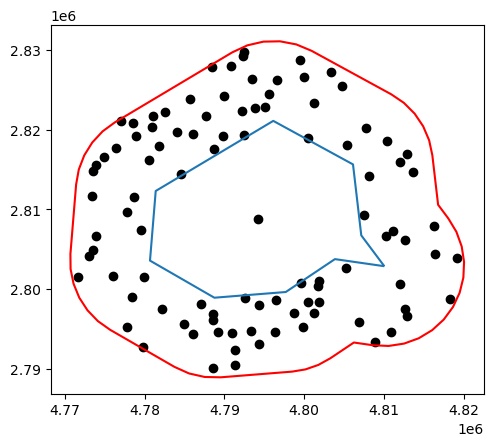

In [22]:
fig, ax = plt.subplots(1)
gdf.boundary.plot(ax=ax)
buffer.boundary.plot(ax=ax, color="red")
cities.plot(ax=ax, color="black")

# (fig:outside-of-region) - Figure to show scale issues with the dataset

C:\Users\arbeit\AppData\Local\Temp\ipykernel_44840\296444782.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


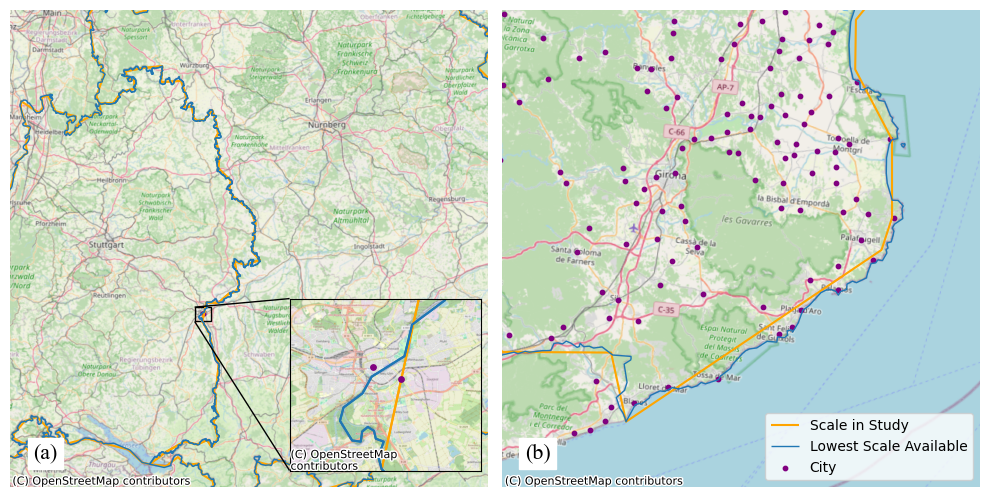

In [24]:
ulmex = """
PREFIX : <http://data.europa.eu/nuts/>
PREFIX gn: <http://www.geonames.org/ontology#>
PREFIX geo: <http://www.opengis.net/ont/geosparql#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
SELECT ?notation ?url ?wkt WHERE {
    ?region a skos:Concept ;
    	skos:notation ?notation ;
    	<https://www.w3.org/ns/locn#geometry> ?geom ;
    	geo:hasGeometry ?geomGS .
    ?geomGS geo:asWKT ?wkt .
    ?geom :scale "01m" ;
    		:projection "ETRS89" .
    ?geom <http://www.w3.org/ns/dcat#distribution> ?distr .
    ?distr <http://www.w3.org/ns/dcat#downloadURL> ?url
    FILTER(?notation = "DE1" || ?notation = "DE2")
}"""
df = sparql_select(ulmex, select_endpoint_url)
gdf = gpd.GeoDataFrame(df, geometry=df.wkt.apply(wkt.loads))
gdf_scale = gpd.GeoDataFrame(df, geometry=df.url.apply(lambda x: shape(requests.get(x).json()['features'][0]['geometry'])))

ulmex = """
PREFIX gn: <https://www.geonames.org/ontology#>
PREFIX geo: <http://www.opengis.net/ont/geosparql#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
SELECT ?notation ?wkt WHERE {
    ?region a gn:Feature ;
    	gn:name ?notation ;
    	geo:hasGeometry ?geom .
    ?geom geo:asWKT ?wkt .
    FILTER(?notation = "Ulm" || ?notation = "Neu-Ulm")
}"""
df = sparql_select(ulmex, select_endpoint_url)
gdf_city = gpd.GeoDataFrame(df, geometry=df.wkt.apply(wkt.loads))

from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

fig, axs = plt.subplots(1, 2, figsize=(10, 20))

ax = axs[0]
gdf.boundary.plot(ax=ax, color="orange", label="Scale in Study")
gdf_scale.boundary.plot(ax=ax, linewidth=1, label="Lowest Scale Available")
gdf_city.plot(ax=ax, markersize=4, color="purple", label="City")
ax.axis("off")
ax.set_xlim(4200000, 4500000)
ax.set_ylim(2700000, 3000000)


ax_inset = inset_axes(ax, width="40%", height="40%", loc='lower right')
gdf.boundary.plot(ax=ax_inset, color='orange')
gdf_scale.boundary.plot(ax=ax_inset)
gdf_city.plot(ax=ax_inset, markersize=15, color="purple", zorder=111)
ax_inset.set_xticks([])
ax_inset.set_yticks([])
ax_inset.set_xlim(4316000, 4326000)
ax_inset.set_ylim(2804000, 2813000)
ctx.add_basemap(ax, crs="EPSG:3035", source=ctx.providers.OpenStreetMap.Mapnik)
ctx.add_basemap(ax_inset, crs="EPSG:3035", source=ctx.providers.OpenStreetMap.Mapnik)

t = ax.text(0.1, 0.05, f"(a)", 
        transform=ax.transAxes,
        fontsize=16,
        fontdict={'family': 'Times New Roman'},
        ha='right',
        va='bottom')
t.set_bbox(dict(facecolor='white', alpha=1, edgecolor="white"))

mark_inset(ax, ax_inset, loc1=2, loc2=3, fc="none", ec="black")

ulmex = """
PREFIX : <http://data.europa.eu/nuts/>
PREFIX gn: <http://www.geonames.org/ontology#>
PREFIX geo: <http://www.opengis.net/ont/geosparql#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
SELECT ?notation ?url ?wkt WHERE {
    ?region a skos:Concept ;
    	skos:notation ?notation ;
    	<https://www.w3.org/ns/locn#geometry> ?geom ;
    	geo:hasGeometry ?geomGS .
    ?geomGS geo:asWKT ?wkt .
    ?geom :scale "01m" ;
    		:projection "ETRS89" .
    ?geom <http://www.w3.org/ns/dcat#distribution> ?distr .
    ?distr <http://www.w3.org/ns/dcat#downloadURL> ?url
    FILTER(?notation = "ES512")
}"""
df = sparql_select(ulmex, select_endpoint_url)
gdf = gpd.GeoDataFrame(df, geometry=df.wkt.apply(wkt.loads))
gdf_scale = gpd.GeoDataFrame(df, geometry=df.url.apply(lambda x: shape(requests.get(x).json()['features'][0]['geometry'])))

ulmex = """
PREFIX gn: <https://www.geonames.org/ontology#>
PREFIX geo: <http://www.opengis.net/ont/geosparql#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
SELECT ?notation ?wkt WHERE {
    ?region a gn:Feature ;
    	gn:name ?notation ;
    	geo:hasGeometry ?geom .
    ?geom geo:asWKT ?wkt .
}"""
df = sparql_select(ulmex, select_endpoint_url)
gdf_city = gpd.GeoDataFrame(df, geometry=df.wkt.apply(wkt.loads))
gdf_city = gpd.clip(gdf_city, gdf.buffer(10000))

ax = axs[1]
gdf.boundary.plot(ax=ax, color="orange", label="Scale in Study")
gdf_scale.boundary.plot(ax=ax, linewidth=1, label="Lowest Scale Available")
gdf_city.plot(ax=ax, markersize=10, color="purple", label="City")
ax.axis("off")
ax.set_xlim(3700000, 3770000)
ax.set_ylim(2080000, 2150000)
ax.legend()

t = ax.text(0.1, 0.05, f"(b)", 
        transform=ax.transAxes,
        fontsize=16,
        fontdict={'family': 'Times New Roman'},
        ha='right',
        va='bottom')
t.set_bbox(dict(facecolor='white', alpha=1, edgecolor="white"))

ctx.add_basemap(ax, crs="EPSG:3035", source=ctx.providers.OpenStreetMap.Mapnik)
plt.tight_layout()
fig.savefig("pics/outside-of-region.png", bbox_inches="tight")